In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, make_checkerboard
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

In [15]:
df_median_age = df_train.groupby(['Sex', 'Pclass'])['Age'].median().reset_index()
df_median_age = df_median_age.rename(columns={'Age' : 'Median_Age'})

df_train = df_train.merge(df_median_age, on=['Sex', 'Pclass'], how='left')
df_train.loc[df_train['Age'].isna(), 'Age'] = df_train['Median_Age']
df_train = df_train.drop(columns = 'Median_Age')

df_test = df_test.merge(df_median_age, on=['Sex', 'Pclass'], how='left')
df_test.loc[df_test['Age'].isna(), 'Age'] = df_test['Median_Age']
df_test = df_test.drop(columns = 'Median_Age')

df_train['Cabin_Type'] = df_train.loc[df_train['Cabin'].notna()]['Cabin'].apply(lambda x: x[0])
df_test['Cabin_Type'] = df_test.loc[df_test['Cabin'].notna()]['Cabin'].apply(lambda x: x[0])

df_train['Cabin_Nos'] = df_train.loc[df_train['Cabin'].notna()]['Cabin'].apply(lambda x: len(x.split()))
df_test['Cabin_Nos'] = df_test.loc[df_test['Cabin'].notna()]['Cabin'].apply(lambda x: len(x.split()))

df_train = df_train.drop(columns='Cabin')
df_test = df_test.drop(columns='Cabin')

# new_df_train = pd.get_dummies(df_train['Sex'])
# df_train = pd.concat([df_train, new_df_train], axis=1)

# new_df_test = pd.get_dummies(df_test['Sex'])
# df_test = pd.concat([df_test, new_df_test], axis=1)

# df_train = df_train.drop(columns=['Sex'])
# df_test = df_test.drop(columns=['Sex'])

df_train['Sex'] = df_train['Sex'].apply(lambda x: 1 if x=='male' else 0)
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1 if x=='male' else 0)

df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

new_df_train = pd.get_dummies(df_train['Embarked'])
new_cols = ['Embarked_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Embarked'])
new_cols = ['Embarked_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Embarked'])
df_test = df_test.drop(columns=['Embarked'])

new_df_train = pd.get_dummies(df_train['Cabin_Type'])
new_cols = ['Cabin_Type_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Cabin_Type'])
new_cols = ['Cabin_Type_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Cabin_Type'])
df_test = df_test.drop(columns=['Cabin_Type'])

class_fare_dict = df_train.groupby('Pclass')['Fare'].median().to_dict()

df_train['Pclass_Fare_median'] = df_train['Pclass'].apply(lambda x: class_fare_dict[x])
df_test['Pclass_Fare_median'] = df_test['Pclass'].apply(lambda x: class_fare_dict[x])

df_train.loc[df_train['Fare'].isna(), 'Fare'] = df_train['Pclass_Fare_median']
df_test.loc[df_test['Fare'].isna(), 'Fare'] = df_test['Pclass_Fare_median']

df_train = df_train.drop(columns = 'Pclass_Fare_median')
df_test = df_test.drop(columns = 'Pclass_Fare_median')

new_df_train = pd.get_dummies(df_train['Pclass'])
new_cols = ['Pclass_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Pclass'])
new_cols = ['Pclass_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Pclass'])
df_test = df_test.drop(columns=['Pclass'])

df_train['Cabin_Nos'] = df_train['Cabin_Nos'].fillna(1)
df_test['Cabin_Nos'] = df_test['Cabin_Nos'].fillna(1)

df_test['Cabin_Type_T'] = 0

In [16]:
inp_col_list = list(df_train.columns.values)
inp_col_list.remove('PassengerId')
inp_col_list.remove('Survived')
inp_col_list.remove('Name')
inp_col_list.remove('Ticket')

inp_col_list.remove('Pclass_1')
inp_col_list.remove('Pclass_2')
inp_col_list.remove('Pclass_3')

inp_col_list.remove('Cabin_Type_A')
inp_col_list.remove('Cabin_Type_B')
inp_col_list.remove('Cabin_Type_C')
inp_col_list.remove('Cabin_Type_D')
inp_col_list.remove('Cabin_Type_E')
inp_col_list.remove('Cabin_Type_F')
inp_col_list.remove('Cabin_Type_G')
inp_col_list.remove('Cabin_Type_T')

inp_col_list.remove('Embarked_C')
inp_col_list.remove('Embarked_Q')
inp_col_list.remove('Embarked_S')

inp_col_list.remove('Parch')
inp_col_list.remove('Cabin_Nos')

# df_train = df_train.loc[df_train['male']==1]
X = df_train[inp_col_list]
y = df_train['Survived']

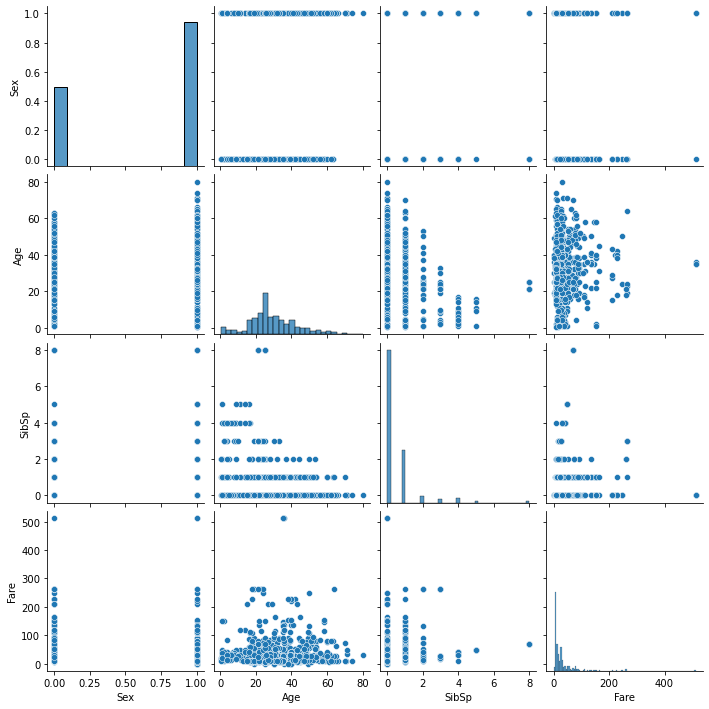

In [17]:
sns.pairplot(X)

In [101]:
# X = StandardScaler().fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

# # pca = PCA(n_components=2)
# # X = pca.fit_transform(X_train)
# # y = y_train
# # X_train = X

# # X_test = pca.fit_transform(X_test)

In [107]:
X = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=3, init='pca',learning_rate='auto', perplexity=5, random_state=42)
X = tsne.fit_transform(X)

/home/madhav/anaconda3/envs/kgl_titanic/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



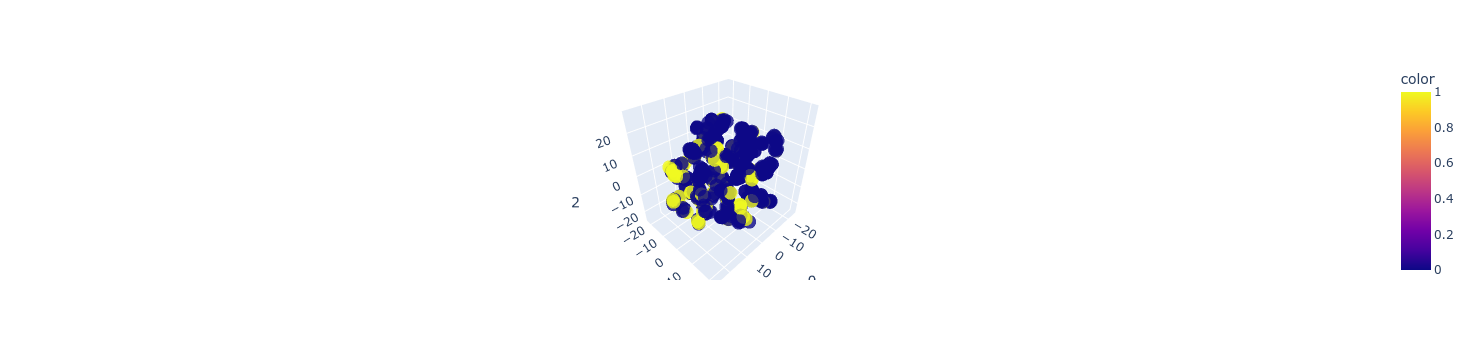

In [108]:
import plotly.express as px
fig = px.scatter_3d(X, x=0, y=1, z=2,
              color=y, opacity=0.8)
fig.show()

In [72]:
names = ["Decision Tree","Random Forest", "ExtraTrees"]
# Creating a Python List with our three Tree classifiers
treeclassifiers = [
    DecisionTreeClassifier(max_depth=5, min_samples_leaf=5),
    RandomForestClassifier(max_depth=5, min_samples_leaf=5, max_features=None),
    ExtraTreesClassifier(max_depth=5, min_samples_leaf=5, max_features=None)]

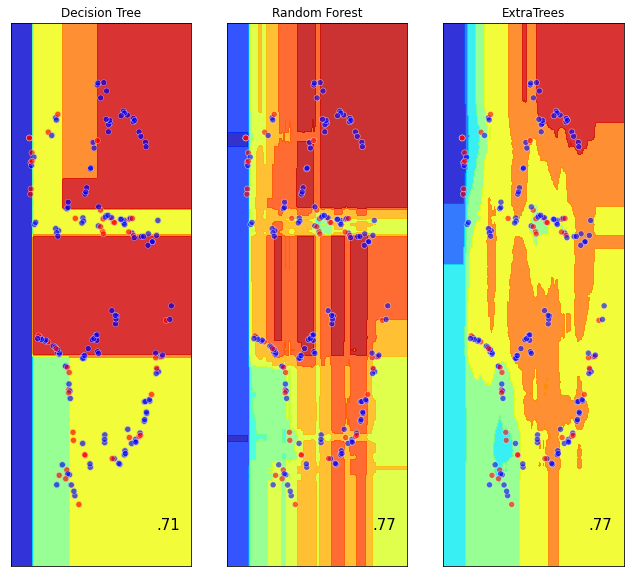

In [73]:
figure = plt.figure(figsize=(12, 10))
h = 0.02
i = 1

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.jet
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(treeclassifiers) + 1, i)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.7)
# and testing points
#ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 1
# iterate over classifiers
for name, clf in zip(names, treeclassifiers):
    ax = plt.subplot(1, len(treeclassifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.6, linewidths=0.6, edgecolors="white")
    # and testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               #alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1
figure.subplots_adjust(left=.02, right=.98)
plt.show()

In [65]:
names = ['SVC Linear', 'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Log Reg', 'Gaussian NB']
linearclassifiers = [
    SVC(kernel="linear", C=0.0025),
    SVC(kernel="poly", C=0.0025),
    SVC(kernel="rbf", C=0.0025),
    SVC(kernel="sigmoid", C=0.0025),
    LogisticRegression(),
    GaussianNB()]

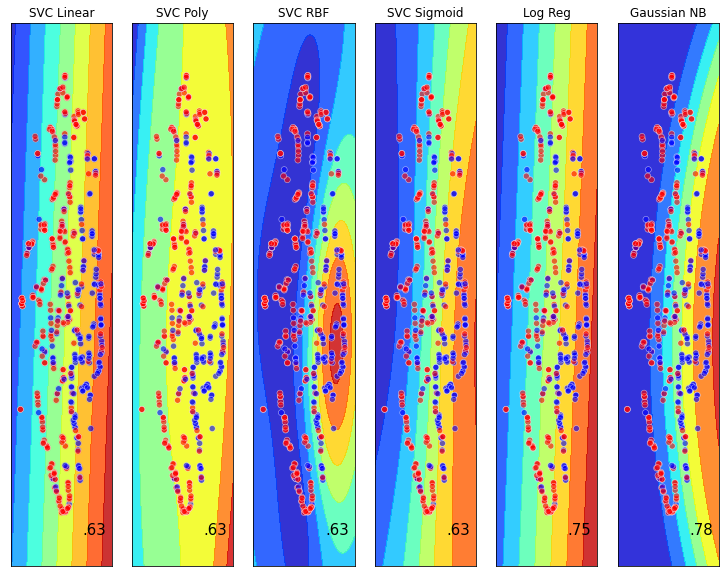

In [66]:
figure = plt.figure(figsize=(12, 10))
h = 0.02
i = 1

# X = StandardScaler().fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.jet
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(linearclassifiers) + 1, i)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.7)
# and testing points
#ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 1
# iterate over classifiers
for name, clf in zip(names, linearclassifiers):
    ax = plt.subplot(1, len(linearclassifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.6, linewidths=0.6, edgecolors="white")
    # and testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               #alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1
figure.subplots_adjust(left=.02, right=.98)
plt.show()

## 